In [31]:
import torch
torch.set_default_device("cuda")
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from datasets import load_dataset

dataset = load_dataset("iwslt2017", "iwslt2017-en-fr")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 232825
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 8597
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 890
    })
})


In [32]:
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

In [33]:
from tqdm import tqdm

# Function to get English and French sentences from the dataset
def get_en_fr_sentences(data):
    english = [item['en'] for item in tqdm(data['translation'])]
    french = [item['fr'] for item in tqdm(data['translation'])]
    return english, french

In [34]:
train_en, train_fr = get_en_fr_sentences(train_data)

# just for testing
train_en = train_en[:10000]
train_fr = train_fr[:10000]

val_en, val_fr = get_en_fr_sentences(val_data)

# just for testing
val_en = val_en[:200]
val_fr = val_fr[:200]

test_en, test_fr = get_en_fr_sentences(test_data)

# just for testing
test_en = test_en[:1000]
test_fr = test_fr[:1000]

100%|██████████| 8597/8597 [00:00<00:00, 1546775.54it/s]


In [35]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to tokenize sentences
def tokenize(sentences, tokenizer):
    tokenized_sentences = tokenizer(
        sentences,
        truncation=True,
        padding=True,
        add_special_tokens=True,
        return_tensors="pt",
        max_length=512
    )
    return tokenized_sentences

In [36]:
tokenized_train_en = tokenize(train_en, tokenizer)
tokenized_train_fr = tokenize(train_fr, tokenizer)

tokenized_val_en = tokenize(val_en, tokenizer)
tokenized_val_fr = tokenize(val_fr, tokenizer)

tokenized_test_en = tokenize(test_en, tokenizer)
tokenized_test_fr = tokenize(test_fr, tokenizer)

In [37]:
class TranslationDataset(Dataset):
    def __init__(self, tokenized_source, tokenized_target):
        self.source_tokens = tokenized_source["input_ids"]
        self.target_tokens = tokenized_target["input_ids"]

    def __len__(self):
        return len(self.source_tokens)

    def __getitem__(self, index):
        source_sequence = self.source_tokens[index]
        target_sequence = self.target_tokens[index]

        return {
            "input_ids": source_sequence,
            "labels": target_sequence,
        }

# Create datasets
train_dataset = TranslationDataset(tokenized_train_en, tokenized_train_fr)
val_dataset = TranslationDataset(tokenized_val_en, tokenized_val_fr)
test_dataset = TranslationDataset(tokenized_test_en, tokenized_test_fr)

In [38]:
from torchscale.architecture.config import EncoderDecoderConfig
from torchscale.architecture.encoder_decoder import EncoderDecoder
from torchscale.component.embedding import PositionalEmbedding, TextEmbedding

enc_dec_config = EncoderDecoderConfig(
    encoder_embed_dim=64,
    encoder_attention_heads=8,
    encoder_ffn_embed_dim=256,
    encoder_layers=8,
    max_source_positions=512,
    decoder_embed_dim=64,
    decoder_attention_heads=8,
    decoder_ffn_embed_dim=256,
    decoder_layers=8,
    activation_fn="gelu",
    max_target_positions=512,
    vocab_size=30000
)
enc_dec = EncoderDecoder(
    enc_dec_config,
    encoder_embed_tokens=TextEmbedding(30000, enc_dec_config.encoder_embed_dim),
    encoder_embed_positions=PositionalEmbedding(enc_dec_config.max_source_positions, enc_dec_config.encoder_embed_dim),
    decoder_embed_tokens=TextEmbedding(30000, enc_dec_config.decoder_embed_dim),
    decoder_embed_positions=PositionalEmbedding(enc_dec_config.max_target_positions, enc_dec_config.decoder_embed_dim)
)

# Print encoder decoder arch
print(enc_dec)

EncoderDecoder(
  (encoder): Encoder(
    (dropout_module): Dropout(p=0.0, inplace=False)
    (embed_tokens): TextEmbedding(30000, 64)
    (embed_positions): PositionalEmbedding(512, 64)
    (layers): ModuleList(
      (0-7): 8 x EncoderLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=64, out_features=64, bias=True)
          (v_proj): Linear(in_features=64, out_features=64, bias=True)
          (q_proj): Linear(in_features=64, out_features=64, bias=True)
          (out_proj): Linear(in_features=64, out_features=64, bias=True)
          (inner_attn_ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout_module): Dropout(p=0.0, inplace=False)
        )
        (self_attn_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout_module): Dropout(p=0.0, inplace=False)
        (ffn): FeedForwardNetwork(
          (activation_dropout_module): Dropout(p=0.0, inplace=False)
          (dropout_module): Dropout(

In [39]:
# Define your optimizer and loss function
optimizer = torch.optim.AdamW(enc_dec.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [40]:
batch_size = 4

# Create data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    enc_dec.train()

    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        src_tokens = batch["input_ids"]
        prev_output_tokens = batch["labels"]

        enc_dec_output1, enc_dec_output2 = enc_dec(src_tokens, prev_output_tokens)

        target_sequence = batch["labels"].view(-1)

        loss = criterion(enc_dec_output1.view(-1, enc_dec_config.vocab_size), target_sequence)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    print(f"Epoch {epoch + 1}, Train Loss: {average_loss}")

    enc_dec.eval()
    with torch.no_grad():
        total_val_loss = 0

        for val_batch in tqdm(val_loader):
            val_src_tokens = val_batch["input_ids"]
            val_prev_output_tokens = val_batch["labels"]

            val_enc_dec_output1, val_enc_dec_output2 = enc_dec(val_src_tokens, val_prev_output_tokens)

            val_loss = criterion(val_enc_dec_output1.view(-1, enc_dec_config.vocab_size), val_batch["labels"].view(-1))
            total_val_loss += val_loss.item()

        average_val_loss = total_val_loss / len(val_loader)
        val_losses.append(average_val_loss)

        print(f"Epoch {epoch + 1}, Validation Loss: {average_val_loss}")

100%|██████████| 2500/2500 [03:03<00:00, 13.62it/s]


Epoch 1, Train Loss: 1.802873052716255


100%|██████████| 50/50 [00:01<00:00, 41.33it/s]


Epoch 1, Validation Loss: 0.9842911726236343


100%|██████████| 2500/2500 [03:13<00:00, 12.94it/s]


Epoch 2, Train Loss: 0.612210629209876


100%|██████████| 50/50 [00:01<00:00, 39.77it/s]


Epoch 2, Validation Loss: 0.5245329788327218


100%|██████████| 2500/2500 [03:18<00:00, 12.59it/s]


Epoch 3, Train Loss: 0.3305562987223268


100%|██████████| 50/50 [00:01<00:00, 42.32it/s]


Epoch 3, Validation Loss: 0.34046810582280157


100%|██████████| 2500/2500 [03:16<00:00, 12.73it/s]


Epoch 4, Train Loss: 0.2051606276549399


100%|██████████| 50/50 [00:01<00:00, 39.00it/s]


Epoch 4, Validation Loss: 0.23990924254059792


100%|██████████| 2500/2500 [03:14<00:00, 12.89it/s]


Epoch 5, Train Loss: 0.13754083185326307


100%|██████████| 50/50 [00:01<00:00, 39.63it/s]


Epoch 5, Validation Loss: 0.18068625152111054


100%|██████████| 2500/2500 [03:13<00:00, 12.91it/s]


Epoch 6, Train Loss: 0.09777195239346474


100%|██████████| 50/50 [00:01<00:00, 36.16it/s]


Epoch 6, Validation Loss: 0.14491862408816814


100%|██████████| 2500/2500 [03:12<00:00, 13.00it/s]


Epoch 7, Train Loss: 0.07184112067965324


100%|██████████| 50/50 [00:01<00:00, 39.90it/s]


Epoch 7, Validation Loss: 0.12088342867791653


100%|██████████| 2500/2500 [03:12<00:00, 12.96it/s]


Epoch 8, Train Loss: 0.05421644692029804


100%|██████████| 50/50 [00:01<00:00, 39.49it/s]


Epoch 8, Validation Loss: 0.10346214251592756


100%|██████████| 2500/2500 [03:10<00:00, 13.09it/s]


Epoch 9, Train Loss: 0.04173056157808751


100%|██████████| 50/50 [00:01<00:00, 39.94it/s]


Epoch 9, Validation Loss: 0.09049399044364691


100%|██████████| 2500/2500 [03:18<00:00, 12.58it/s]


Epoch 10, Train Loss: 0.03270374424225884


100%|██████████| 50/50 [00:01<00:00, 39.09it/s]

Epoch 10, Validation Loss: 0.08347753058187664


In [42]:
enc_dec.eval()
with torch.no_grad():
    total_test_loss = 0

    for test_batch in tqdm(test_loader):
        test_src_tokens = test_batch["input_ids"]
        test_prev_output_tokens = test_batch["labels"]

        test_enc_dec_output1, test_enc_dec_output2 = enc_dec(test_src_tokens, test_prev_output_tokens)

        test_loss = criterion(test_enc_dec_output1.view(-1, enc_dec_config.vocab_size), test_batch["labels"].view(-1))
        total_test_loss += test_loss.item()

    average_test_loss = total_test_loss / len(test_loader)

    print(f"Final Test Loss: {average_test_loss}")

100%|██████████| 250/250 [00:06<00:00, 40.75it/s]

Final Test Loss: 0.0627327798102051


In [43]:
from torchtext.data.metrics import bleu_score

enc_dec.eval()

candidate_corpus = []
reference_corpus = []

with torch.no_grad():
    for batch in tqdm(train_loader):
        src_tokens = batch['input_ids']
        prev_output_tokens = batch['labels']

        op, _ = enc_dec(src_tokens, prev_output_tokens)

        predictions = torch.argmax(op, dim=-1)

        # Convert token IDs to strings
        candidates = [tokenizer.decode(pred, skip_special_tokens=True) for pred in predictions.cpu().numpy().tolist()]
        candidate_corpus.extend(candidates)

        references = [tokenizer.decode(seq, skip_special_tokens=True).split() for seq in batch['labels'].cpu().numpy().tolist()]
        reference_corpus.extend(references)

candidate_corpus = [str(candidate) for candidate in candidate_corpus]

bleu = bleu_score(candidate_corpus, reference_corpus)
print(f"BLEU score: {bleu}")

100%|██████████| 2500/2500 [01:28<00:00, 28.25it/s]


BLEU score: 0.34018057584762573


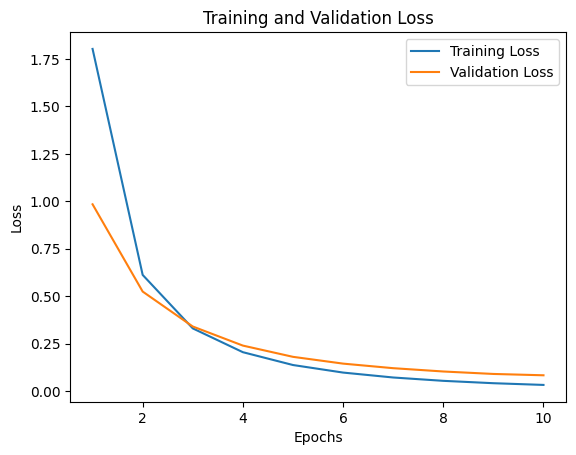

In [44]:
import matplotlib.pyplot as plt 
%matplotlib inline 

epochs = range(1, 11)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()